In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
from scipy.special import rel_entr

In [12]:
# List of available dataset
df18 = pd.read_csv("../exp1-inf/predictions_res18.csv")
df50 = pd.read_csv("../exp1-inf/predictions_res50.csv")
df101 = pd.read_csv("../exp1-inf/predictions_res101.csv")
label = pd.read_csv("../exp1-inf/labels.csv")
binnum=6

In [13]:
prediction = pd.DataFrame({
    "pred18": df18.idxmax(axis=1),
    "pred50": df50.idxmax(axis=1),
    "pred101": df101.idxmax(axis=1),
    "target": label['target']
})
prediction["pred18"] = prediction["pred18"].str.extract('(\d+)').astype(int)
prediction["pred50"] = prediction["pred50"].str.extract('(\d+)').astype(int)
prediction["pred101"] = prediction["pred101"].str.extract('(\d+)').astype(int)

In [14]:
prediction.head()

,pred18,pred50,pred101,target
0,12,68,76,49
1,33,16,33,33
2,30,55,72,72
3,51,51,51,51
4,71,71,71,71


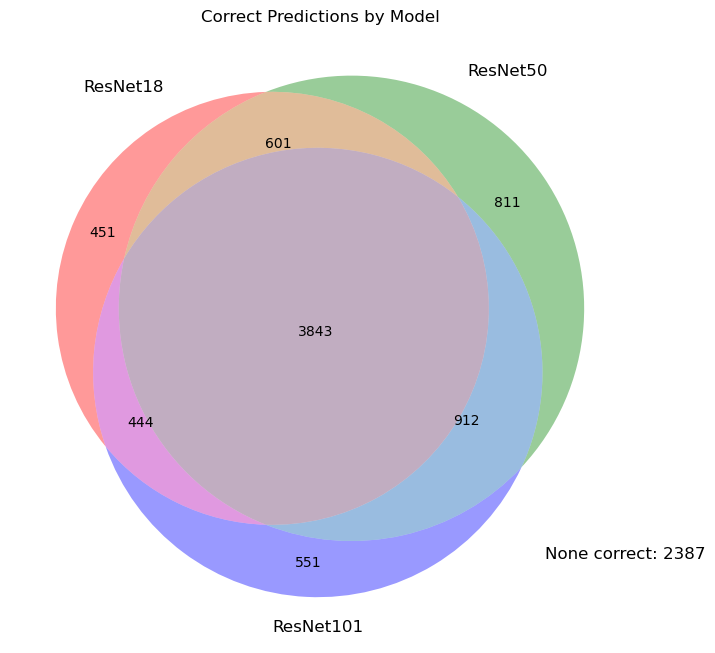

In [15]:
# Accuracy Venn Diagram:
df = prediction
correct_18 = set(df[df['pred18'] == df['target']].index)
correct_50 = set(df[df['pred50'] == df['target']].index)
correct_101 = set(df[df['pred101'] == df['target']].index)
total_indices = set(df.index)
incorrect_all = total_indices - (correct_18 | correct_50 | correct_101)
plt.figure(figsize=(8, 8))
venn_diagram = venn3([correct_18, correct_50, correct_101], ('ResNet18', 'ResNet50', 'ResNet101'))
plt.title('Correct Predictions by Model')
plt.text(0.5, -0.5, f'None correct: {len(incorrect_all)}', fontsize=12)
plt.show()

ou_res18=0.36751593504088775 | ou_res50=0.2588155342712535 | ou_res101=0.28971527020996146


Text(0, 0.5, 'Density')

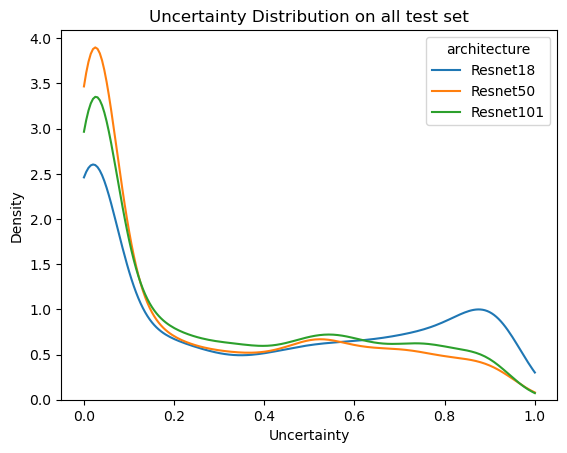

In [16]:
# Uncertainty Visualization
df18["uncertainty"]=1-df18.pow(2).sum(axis=1) # Brier Score
df50["uncertainty"]=1-df50.pow(2).sum(axis=1)
df101["uncertainty"]=1-df101.pow(2).sum(axis=1)
ou_res18 = df18["uncertainty"].mean()
ou_res50 = df50["uncertainty"].mean()
ou_res101 = df101["uncertainty"].mean()
print(f"{ou_res18=} | {ou_res50=} | {ou_res101=}")
sns.kdeplot(df18['uncertainty'], clip=[0, 1], label='Resnet18')
sns.kdeplot(df50['uncertainty'], clip=[0, 1], label='Resnet50')
sns.kdeplot(df101['uncertainty'], clip=[0, 1], label='Resnet101')
plt.legend(title='architecture')
plt.title('Uncertainty Distribution on all test set')
plt.xlabel('Uncertainty')
plt.ylabel('Density')

oc_res18=0.8715682656677265 | oc_res50=0.8837061005793636 | oc_res101=0.8710843226908104


Text(0, 0.5, 'Density')

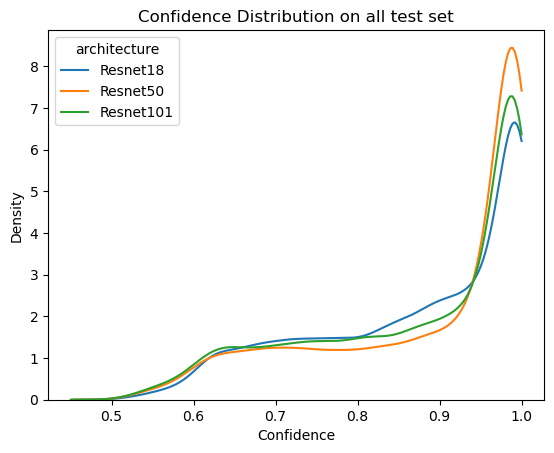

In [17]:
df18["confidence"]=df18.max(axis=1) # prediction confidence
df50["confidence"]=df50.max(axis=1)
df101["confidence"]=df101.max(axis=1)
oc_res18 = df18["confidence"].mean()
oc_res50 = df50["confidence"].mean()
oc_res101 = df101["confidence"].mean()
print(f"{oc_res18=} | {oc_res50=} | {oc_res101=}")
sns.kdeplot(df18['confidence'], clip=[0, 1], label='Resnet18')
sns.kdeplot(df50['confidence'], clip=[0, 1], label='Resnet50')
sns.kdeplot(df101['confidence'], clip=[0, 1], label='Resnet101')
plt.title('Confidence Distribution on all test set')
plt.legend(title='architecture')
plt.xlabel('Confidence')
plt.ylabel('Density')

In [18]:
df["acc18"] = np.where(df["pred18"]==df["target"],1,0)
df["acc50"] = np.where(df["pred50"]==df["target"],1,0)
df["acc101"] = np.where(df["pred101"]==df["target"],1,0)
oa_res18 = df["acc18"].mean()
oa_res50 = df["acc50"].mean()
oa_res101 = df["acc101"].mean()
print(f"{oa_res18=} | {oa_res50=} | {oa_res101=}")

oa_res18=0.5339 | oa_res50=0.6167 | oa_res101=0.575


,pred18,pred50,pred101,target,acc18,acc50,acc101,kl_18_50,kl_18_101,kl_50_18,kl_50_101,kl_101_18,kl_101_50
0,12,68,76,49,0,0,0,1.478515,0.800186,1.175427,0.148640,0.729688,0.953925
1,33,16,33,33,1,0,1,1.096354,-0.778325,1.608931,1.302598,0.698316,0.988962


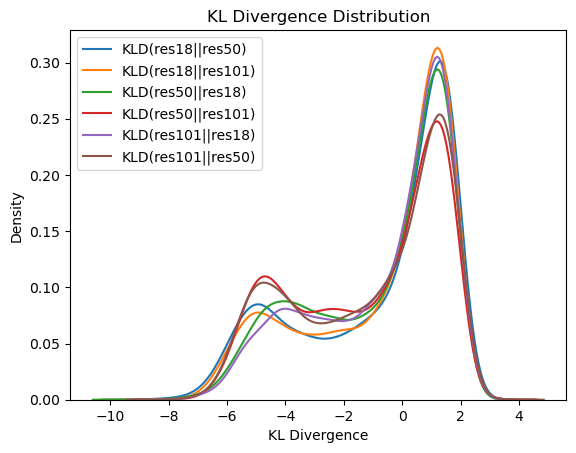

In [19]:
def calc_kl(Q,P,numclass):
    return np.log(rel_entr(Q.iloc[:,0:numclass],P.iloc[:,0:numclass]).sum(1))
df["kl_18_50"] = calc_kl(df18,df50,100)
df["kl_18_101"] = calc_kl(df18,df101,100)
df["kl_50_18"] = calc_kl(df50,df18,100)
df["kl_50_101"] = calc_kl(df50,df101,100)
df["kl_101_18"] = calc_kl(df101,df18,100)
df["kl_101_50"] = calc_kl(df101,df50,100)
display(df.head(2))
sns.kdeplot(df["kl_18_50"], label='KLD(res18||res50)')
sns.kdeplot(df["kl_18_101"], label='KLD(res18||res101)')
sns.kdeplot(df["kl_50_18"], label='KLD(res50||res18)')
sns.kdeplot(df["kl_50_101"], label='KLD(res50||res101)')
sns.kdeplot(df["kl_101_18"], label='KLD(res101||res18)')
sns.kdeplot(df["kl_101_50"], label='KLD(res101||res50)')
plt.title('KL Divergence Distribution')
plt.xlabel('KL Divergence')
plt.ylabel('Density')
plt.legend()

bin_kl
(-9.029, -5.841]     354
(-5.841, -2.673]    2243
(-2.673, 0.495]     2693
(0.495, 3.663]      4695
(3.663, 6.832]         0
(6.832, 10.0]         15
Name: count, dtype: int64


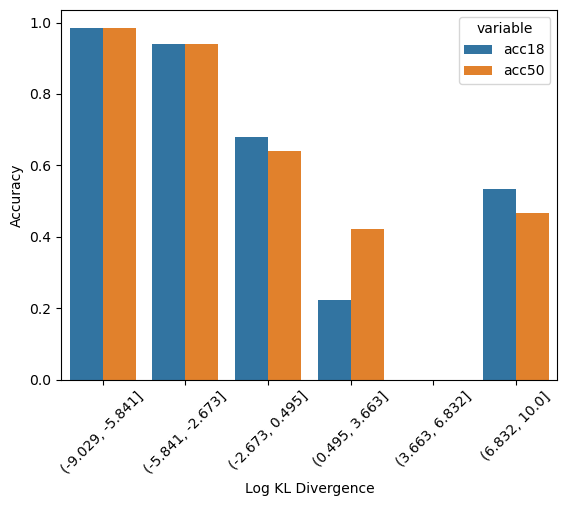

bin_kl
(-9.17, -5.959]      235
(-5.959, -2.767]    2126
(-2.767, 0.425]     2758
(0.425, 3.616]      4878
(3.616, 6.808]         0
(6.808, 10.0]          3
Name: count, dtype: int64


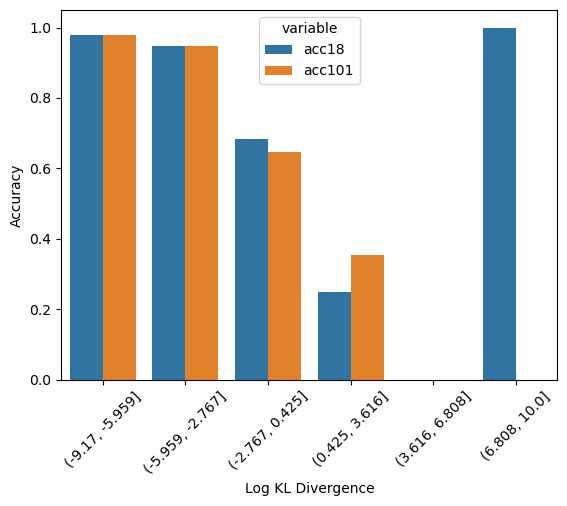

bin_kl
(-9.474, -7.455]       9
(-7.455, -5.449]     337
(-5.449, -3.442]    1621
(-3.442, -1.436]    1486
(-1.436, 0.571]     2303
(0.571, 2.577]      4244
Name: count, dtype: int64


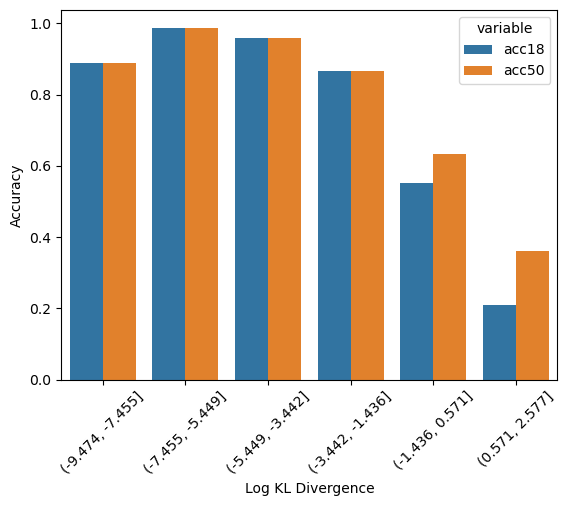

bin_kl
(-8.0, -4.985]       918
(-4.985, -1.988]    2695
(-1.988, 1.009]     3734
(1.009, 4.006]      2651
(4.006, 7.003]         0
(7.003, 10.0]          2
Name: count, dtype: int64


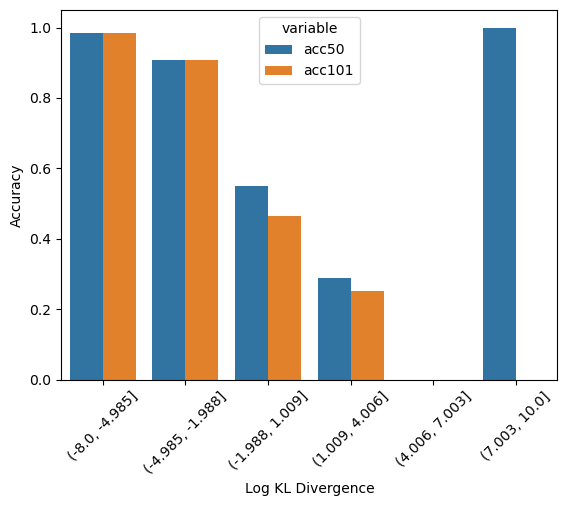

bin_kl
(-8.207, -6.386]      53
(-6.386, -4.576]     760
(-4.576, -2.766]    1415
(-2.766, -0.955]    1328
(-0.955, 0.855]     2771
(0.855, 2.665]      3673
Name: count, dtype: int64


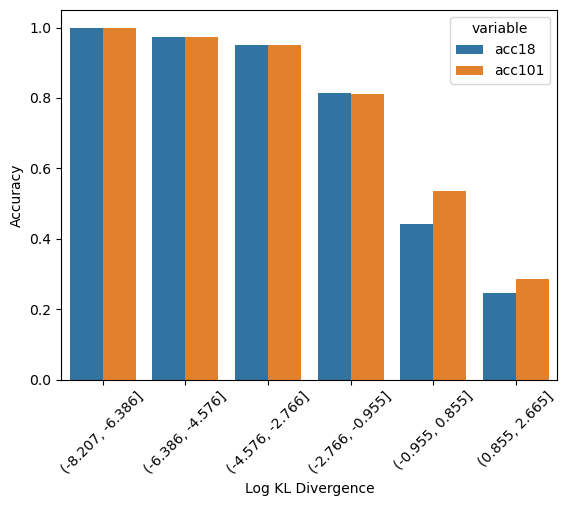

bin_kl
(-8.248, -5.192]     721
(-5.192, -2.153]    2595
(-2.153, 0.885]     3473
(0.885, 3.923]      3196
(3.923, 6.962]         0
(6.962, 10.0]         15
Name: count, dtype: int64


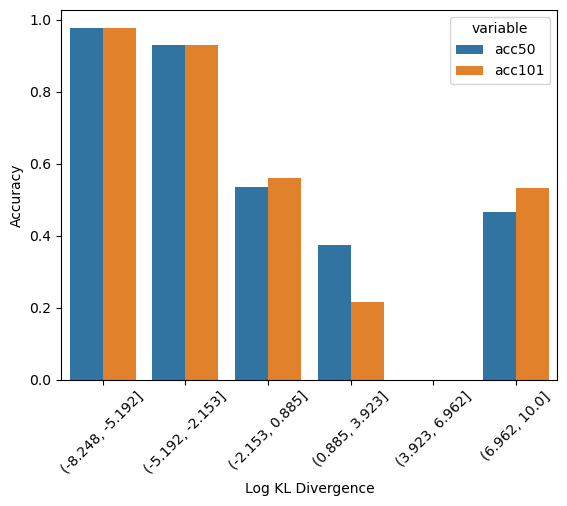

In [20]:
def bin_kl_vis(df_in, binnum,kl_name,acc_col1,acc_col2):
    df=df_in
    tempcol = "bin_kl"
    df[tempcol] = pd.cut(df[kl_name].clip(-20,10), bins=binnum)
    print(df[tempcol].value_counts().sort_index())
    grouped = df.groupby(tempcol)[[acc_col1,acc_col2]].mean().reset_index()
    melted_grouped = grouped.melt(id_vars=tempcol, var_name='variable', value_name='value')
    sns.barplot(x=tempcol, y='value', hue='variable', data=melted_grouped)
    plt.xticks(rotation=45)
    plt.xlabel("Log KL Divergence")
    plt.ylabel("Accuracy")
    plt.show()
bin_kl_vis(df, binnum, "kl_18_50", "acc18", "acc50")
bin_kl_vis(df, binnum, "kl_18_101", "acc18", "acc101")
bin_kl_vis(df, binnum, "kl_50_18", "acc18", "acc50")
bin_kl_vis(df, binnum, "kl_50_101", "acc50", "acc101")
bin_kl_vis(df, binnum, "kl_101_18", "acc18", "acc101")
bin_kl_vis(df, binnum, "kl_101_50", "acc50", "acc101")